🔄 启动分析模式: SUMMER | 目标行业数: 1
📊 [B、城乡居民生活用电合计] 基线锁定: 工作日 10401 / 周末 10575
📊 图表已保存: E:\A智网\日常监测\空调电量计算\summer_B、城乡居民生活用电合计.png


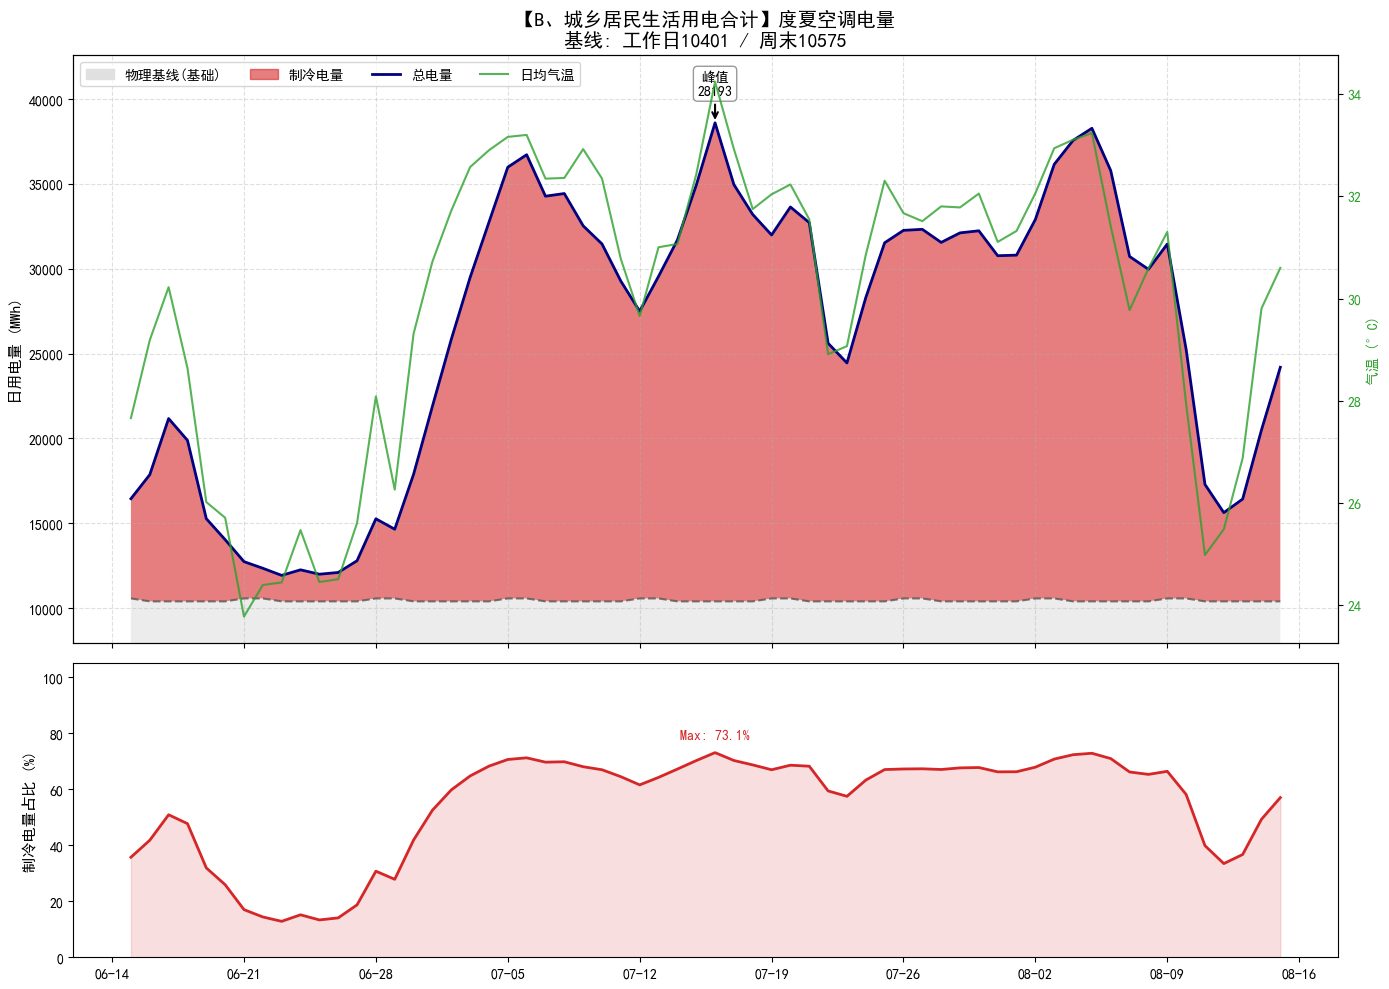

: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import warnings
import platform

# --- 1. 全局配置与环境设置 ---
warnings.filterwarnings('ignore')

# 自动配置字体，适配 Windows/Mac/Linux
system_name = platform.system()
if system_name == 'Windows':
    plt.rcParams['font.sans-serif'] = ['SimHei']
elif system_name == 'Darwin':  # Mac
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
else:
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans'] # Linux fallback
plt.rcParams['axes.unicode_minus'] = False

SEASON_1 = '度夏'

# 季节配置字典 (方便修改年份)
SEASON_CONFIG = {
    'summer': {
        'anchor': ('2025-04-01', '2025-05-15'),  # 基准期
        'focus':  ('2025-06-15', '2025-09-30'),  # 核心分析期
        'temp_color': '#2ca02c',                 # 绿色
        'load_color': '#d62728',                 # 红色
        'label': '制冷电量',
        'desc': '骤冷回调'
    },
    'winter': {
        'anchor': ('2024-10-01', '2024-11-15'),
        'focus':  ('2024-12-01', '2025-02-28'),
        'temp_color': '#1f77b4',                 # 蓝色
        'load_color': '#ff7f0e',                 # 橙色
        'label': '取暖电量',
        'desc': '回暖回调'
    }
}

def load_data(file_path):
    """读取并清洗数据"""
    try:
        # 尝试不同编码
        try:
            df = pd.read_csv(file_path, encoding='gbk')
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, encoding='utf-8')
            
        # 统一列名格式（去除空格）
        df.columns = df.columns.str.strip()
        
        # 转换日期
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date').reset_index(drop=True)
        
        # 确保数值列为浮点型
        cols_to_numeric = ['load_MWh', 'temp_mean']
        for col in cols_to_numeric:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                
        return df
    except Exception as e:
        print(f"❌ 读取文件失败: {e}")
        return None

def auto_detect_events(df, load_col='climate_load', ratio_col='ratio'):
    """
    【智能侦探】自动寻找关键日期
    """
    events = {}
    if df.empty: return events
    
    # 1. 寻找峰值 (占比最高点)
    max_idx = df[ratio_col].idxmax()
    
    events['peak'] = {
        'date': df.loc[max_idx, 'date'],
        'ratio': df.loc[max_idx, ratio_col],
        'load': df.loc[max_idx, load_col],
        'total_load': df.loc[max_idx, 'load_MWh'],
        'base_load': df.loc[max_idx, 'fixed_base']
    }

    # 2. 寻找“深谷” (峰值所在月内的最低占比)
    peak_month = events['peak']['date'].month
    df_core = df[df['date'].dt.month == peak_month]
    
    if not df_core.empty:
        min_idx = df_core[ratio_col].idxmin()
        events['valley'] = {
            'date': df.loc[min_idx, 'date'],
            'ratio': df.loc[min_idx, ratio_col]
        }
    else:
        events['valley'] = None

    return events

def analyze_universal_climate_load(file_path, target_names, output_folder, mode='summer'):
    """
    【夏冬通用分析器】核心逻辑
    """
    if mode not in SEASON_CONFIG:
        print(f"❌ 模式错误: {mode}，仅支持 'summer' 或 'winter'")
        return

    # 获取配置
    cfg = SEASON_CONFIG[mode]
    if not os.path.exists(output_folder): os.makedirs(output_folder)
    
    print(f"🔄 启动分析模式: {mode.upper()} | 目标行业数: {len(target_names)}")
    
    df_raw = load_data(file_path)
    if df_raw is None: return

    for target in target_names:
        # 筛选行业
        df = df_raw[df_raw['行业名称'].astype(str).str.strip() == target].copy()
        if len(df) == 0:
            print(f"⚠️ 未找到行业数据: {target}")
            continue

        # --- 1. 物理基线锚定 ---
        anchor_mask = (df['date'] >= cfg['anchor'][0]) & (df['date'] <= cfg['anchor'][1])
        df_anchor = df[anchor_mask]
        
        if len(df_anchor) > 5: # 至少要有几天数据才算有效
            base_weekday = df_anchor[df_anchor['date'].dt.dayofweek <= 4]['load_MWh'].mean()
            base_weekend = df_anchor[df_anchor['date'].dt.dayofweek >= 5]['load_MWh'].mean()
            # 如果周末数据缺失，用工作日代替
            if pd.isna(base_weekend): base_weekend = base_weekday
        else:
            print(f"⚠️ [{target}] 缺少基准期数据，使用全局最小值替代。")
            base_weekday = df['load_MWh'].min()
            base_weekend = base_weekday

        print(f"📊 [{target}] 基线锁定: 工作日 {base_weekday:.0f} / 周末 {base_weekend:.0f}")

        # --- 2. 向量化计算 (速度优化) ---
        # 标记周末
        df['is_weekend'] = df['date'].dt.dayofweek >= 5
        # 匹配基线
        df['fixed_base'] = np.where(df['is_weekend'], base_weekend, base_weekday)
        
        # 计算气象电量 (clip防止负数)
        df['climate_load'] = (df['load_MWh'] - df['fixed_base']).clip(lower=0)
        
        # 计算占比 (防止除以0)
        df['ratio'] = np.where(
            df['load_MWh'] > 0, 
            (df['climate_load'] / df['load_MWh']) * 100, 
            0
        )

        # --- 3. 聚焦核心时段 ---
        focus_mask = (df['date'] >= cfg['focus'][0]) & (df['date'] <= cfg['focus'][1])
        df_focus = df[focus_mask].copy().reset_index(drop=True)
        
        if len(df_focus) == 0:
            print(f"⚠️ [{target}] 核心时段无数据，跳过。")
            continue

        # --- 4. 智能侦探 ---
        events = auto_detect_events(df_focus)

        # 保存结果
        file_name = f"{mode}_{target}_分析结果.xlsx"
        df_focus.to_excel(os.path.join(output_folder, file_name), index=False)

        # --- 5. 专业绘图 ---
        plot_analysis(df_focus, events, target, mode, cfg, base_weekday, base_weekend, output_folder)

def plot_analysis(df, events, target, mode, cfg, base_wd, base_we, output_folder):
    """
    独立的绘图函数 (已优化 Y 轴范围)
    """
    # 创建画布
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
    
    # ==========================================
    # 1. 上图：电量堆叠图
    # ==========================================
    ax1.set_title(f"【{target}】{SEASON_1}空调电量\n基线: 工作日{base_wd:.0f} / 周末{base_we:.0f}", fontsize=14, fontweight='bold')
    
    # 绘制堆叠区域 (基线 + 气象电量)
    # 注意：为了美观，基线部分用浅灰色，气象电量用配置色
    ax1.stackplot(df['date'], df['fixed_base'], df['climate_load'], 
                  labels=['物理基线', cfg['label']], 
                  colors=['#e0e0e0', cfg['load_color']], alpha=0.6, edgecolor='none')
    
    # 绘制总电量线 (深色线条勾勒轮廓，更清晰)
    l2, = ax1.plot(df['date'], df['load_MWh'], color='#000080', linewidth=2, label='总电量')
    
    # 绘制基线轮廓 (虚线)
    l1, = ax1.plot(df['date'], df['fixed_base'], color='#555555', linestyle='--', linewidth=1.5, alpha=0.8)
    
    # --- 🔥 核心修改：动态设置 Y 轴范围 🔥 ---
    # 计算数据的最小值和最大值
    y_min = df['load_MWh'].min()
    y_max = df['load_MWh'].max()
    y_range = y_max - y_min
    
    # 设置下限：最小值减去 15% 的波动范围，但不能小于 0
    # 这样可以去除底部的空白，同时保留一点“呼吸感”
    y_bottom = max(0, y_min - y_range * 0.15)
    y_top = y_max + y_range * 0.15
    
    ax1.set_ylim(bottom=y_bottom, top=y_top)
    # ---------------------------------------

    # 标注峰值
    if events.get('peak'):
        pk = events['peak']
        ax1.annotate(f"峰值\n{pk['load']:.0f}", 
                     xy=(pk['date'], pk['total_load']), 
                     xytext=(0, 20), textcoords='offset points',
                     arrowprops=dict(arrowstyle='->', color='black', lw=1.5), 
                     ha='center', fontweight='bold', fontsize=10,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)) # 加个白底框更清晰

    ax1.set_ylabel('日用电量 (MWh)', fontsize=11)
    ax1.grid(True, linestyle='--', alpha=0.4) # 网格线淡一点
    
    # 双轴绘制气温
    ax1_temp = ax1.twinx()
    l3, = ax1_temp.plot(df['date'], df['temp_mean'], color=cfg['temp_color'], linestyle='-', linewidth=1.5, label='日均气温', alpha=0.8)
    ax1_temp.set_ylabel('气温 (°C)', color=cfg['temp_color'])
    ax1_temp.tick_params(axis='y', labelcolor=cfg['temp_color'])

    # 合并图例 (优化版)
    import matplotlib.patches as mpatches
    # 手动创建图例句柄，确保颜色对应正确
    legend_handles = [
        mpatches.Patch(color='#e0e0e0', label='物理基线(基础)'),
        mpatches.Patch(color=cfg['load_color'], alpha=0.6, label=cfg['label']),
        l2, # 总电量线
        l3  # 气温线
    ]
    ax1.legend(handles=legend_handles, loc='upper left', frameon=True, ncol=4, fontsize=10)

    # ==========================================
    # 2. 下图：占比分析
    # ==========================================
    ax2.plot(df['date'], df['ratio'], color=cfg['load_color'], linewidth=2, label=f'{cfg["label"]}占比')
    ax2.fill_between(df['date'], 0, df['ratio'], color=cfg['load_color'], alpha=0.15)
    
    # 标注最高占比
    if events.get('peak'):
        pk = events['peak']
        ax2.annotate(f'Max: {pk["ratio"]:.1f}%', 
                     xy=(pk['date'], pk['ratio']), 
                     xytext=(0, 10), textcoords='offset points',
                     color=cfg['load_color'], fontweight='bold', ha='center')

    # 标注深谷
    if events.get('valley'):
        val = events['valley']
        if val['ratio'] < pk['ratio'] * 0.7:
            ax2.annotate(f"{cfg['desc']}\n{val['ratio']:.1f}%", 
                         xy=(val['date'], val['ratio']), 
                         xytext=(0, 15), textcoords='offset points',
                         arrowprops=dict(arrowstyle='->', color='black'), 
                         ha='center', fontsize=9)

    ax2.set_ylabel(f'{cfg["label"]}占比 (%)', fontsize=11)
    ax2.set_ylim(0, 105) 
    
    # 日期格式化
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax2.xaxis.set_major_locator(mdates.DayLocator(interval=7)) 
    plt.xticks(rotation=0)
    
    plt.tight_layout()
    
    # 保存图片
    save_img = os.path.join(output_folder, f"{mode}_{target}.png")
    plt.savefig(save_img, dpi=300, bbox_inches='tight')
    print(f"📊 图表已保存: {save_img}")
    plt.show()
    # plt.close()

if __name__ == "__main__":
    # --- 用户配置区 ---
    input_file = r"E:\A智网\电量预测数据\lightgbm模型\133个行业电量与天气对齐数据_0815.csv"
    output_dir = r"E:\A智网\日常监测\空调电量计算" 
    
    # 目标行业列表
    targets = ["B、城乡居民生活用电合计"]
    
    # 运行分析
    analyze_universal_climate_load(input_file, targets, output_dir, mode='summer')